## Computer Vision Lab ##



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np



from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset (MNIST)

We will use the pytorch dataset and dataloader as seen in the previous lab. We will apply some needed transformation to the data

In [12]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes (0 to 9)
root_dir = '/content/drive/MyDrive/Work/PHD/courses-AML/data'

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

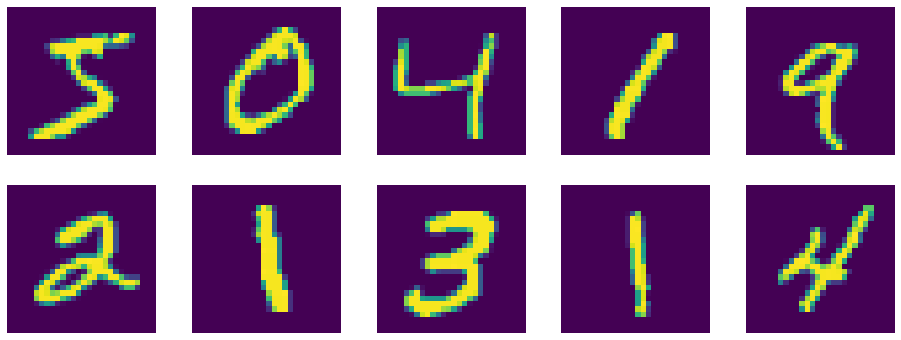

In [13]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

CNN

In [14]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5) # 6 channels and kernel_size 5
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False): # [batch_size, channel, width, height] - [64, 1, 28, 28]
        # First CONV
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        
        # Second CONV
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        # [64, 6, 4, 4]
        
#         x = x.view(-1, self.n_feature*4*4)
        x = self.flatten(x) # [64, n_feature * 4 * 4]
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
tensor = torch.rand([1, 1, 28, 28]) #Batch size, channel, width, height (what the network expect)
print(tensor.shape)

torch.Size([1, 1, 28, 28])


In [16]:
conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
relu_1 = F.relu
max_pool_1 = nn.MaxPool2d(kernel_size=2)

result = conv_1(tensor)
print("after conv1: ", result.shape) 
#Tensor is reshaped from [1, 1, 28, 28] to [1, 6, 24, 24]
# 6 are the number of out_channels specified
# and it reduces w and h to 24, 24 because of the kernel_size (kernel_size - 1) and stride (stride = 1)

result = relu_1(result)
print("after relu1: ", result.shape)

result = max_pool_1(result)
print("after max_pooling_1: ", result.shape) 
# tensor is reshaped from [1, 6, 24, 24] to [1, 6, 12, 12]
# max pooling downsamples dividing by kernel_size

after conv1:  torch.Size([1, 6, 24, 24])
after relu1:  torch.Size([1, 6, 24, 24])
after max_pooling_1:  torch.Size([1, 6, 12, 12])


In [17]:
conv_2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5)
relu_2 = F.relu
max_pool_2 = nn.MaxPool2d(kernel_size=2)

result = conv_2(result)
print("after conv2: ", result.shape)

result = relu_2(result)
print("after relu2: ", result.shape)

result = max_pool_2(result)
print("after max_pooling_2: ", result.shape)
print("shape is [1, 6*4*4]: ", 6*4*4)

after conv2:  torch.Size([1, 6, 8, 8])
after relu2:  torch.Size([1, 6, 8, 8])
after max_pooling_2:  torch.Size([1, 6, 4, 4])
shape is [1, 6*4*4]:  96


In [18]:
flatten_operation = nn.Flatten()

result_flattened = flatten_operation(result)
print("after flattening: ", result_flattened.shape)

result_with_view = result.view(-1, 6*4*4)
print("after view: ", result_with_view.shape)

after flattening:  torch.Size([1, 96])
after view:  torch.Size([1, 96])


In [19]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
print(model_cnn)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)))

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Number of parameters: 6422


## Train and Test CNN







In [20]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [21]:

accuracy_list = []
loss_list = []

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
 
    
    precision,recall,f1,accuracy_score= precision_recall_fscore_support(target.cpu(), pred, average='macro')
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("f Measure = {}".format(f1))
    
    return 
      

# Train CNN, calculate accuracy, loss, recall, precision F1

In [22]:
for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296354
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.760831
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.364109
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.336517
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.599291
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.345536
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.179141
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.105566
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.200805
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.271156

Test set: Average loss: 0.1956, Accuracy: 9406/10000 (94%)

Precision = 0.9458199396920609
Recall = 0.9398202514069937
f Measure = 0.9407241755527108


Create MLP model

In [23]:
# Create Model Classes

class MLP(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(MLP, self).__init__()
        self.n_feature = n_feature
        self.fc1 = nn.Linear(784, 380) #defining fully connected with input 784 and output 380
        self.fc2 = nn.Linear(380, 60) #defining fully connected with input 380 and output 60
        self.fc3 = nn.Linear(60, 10) #defining fully connected with input 60 and output 10
        self.relu = nn.ReLU() #defining Rectified Linear Unit as activation function
        
    def forward(self, x, verbose=False): # [batch_size, channel, width, height] - [64, 1, 28, 28]
        layer1 = x.view(-1, 784) #make it flat in one dimension from 0 - 784
        layer2 = self.relu(self.fc1(layer1)) #layer2 = layer1 -> fc1 -> relu
        layer3 = self.relu(self.fc2(layer2)) #layer3 = layer2 -> fc2 -> relu
        layer4 = self.relu(self.fc3(layer3)) #layer4 = layer3 -> fc2 -> relu
        return F.log_softmax(layer4) #softmax activation to layer4

In [24]:
tensor = torch.rand([1, 1, 28, 28]) #Batch size, channel, width, height (what the network expect)
print(tensor.shape)

torch.Size([1, 1, 28, 28])


In [25]:
model_mlp = MLP(input_size, n_features, output_size)
print(model_mlp)
model_mlp.to(device)
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)))

MLP(
  (fc1): Linear(in_features=784, out_features=380, bias=True)
  (fc2): Linear(in_features=380, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
  (relu): ReLU()
)
Number of parameters: 321770


Training and testing MLP model

In [26]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [27]:
# model testing
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        test_loss /= len(test_loader.dataset)
        
        accuracy = 100. * correct / len(test_loader.dataset)
        
        
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    
    precision,recall,f1,accuracy_score= precision_recall_fscore_support(target.cpu(), pred, average='macro')
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("f Measure = {}".format(f1))
   



Train, calculate, loss, accuracy, precision, recall and F1 for MLP

In [28]:
# Training settings 

for epoch in range(0, 1):
    train(epoch, model_mlp)
    test(model_mlp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297945
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.576164
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.894104
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.709896
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.985575
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.438267
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.345320
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.622765
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.519692
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.528752

Test set: Average loss: 0.0464, Accuracy: 8352/10000 (84%)

Precision = 0.7739572419928766
Recall = 0.8366138409458976
f Measure = 0.800568951738177


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fine tuning pretrained models

In [1]:
#Import Libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Change root dir to wherever your data is! 
data_path = '/content/drive/MyDrive'
specfic_hymenoptera = '/content/drive/MyDrive/hymenoptera.zip'
#!ls "$root_dir"
root_dir = "/content/data"

!unzip "/content/drive/MyDrive/hymenoptera.zip" -d "$root_dir"


# Data is transformed to have variation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = root_dir + '/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Archive:  /content/drive/MyDrive/hymenoptera.zip
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/data/hymenoptera_data/hymenoptera_data/train

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


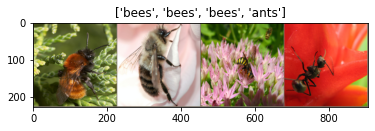

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Train the model
def train_model(model, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    print('train Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))

In [5]:
# Test the model
def test_model(model, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [12]:
# Visualize the model
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

using resnet18 to create layers

In [13]:
# Create the model
model_ft = models.resnet18(pretrained=True)
print(model_ft)
num_ftrs = model_ft.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Train the model
num_epochs = 4

criterion = nn.CrossEntropyLoss()

# We are optimizing
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print()
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 0/3



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5914 Acc: 0.7213
test Loss: 0.3337 Acc: 0.8562
Epoch 1/3

train Loss: 0.6199 Acc: 0.7746
test Loss: 0.3283 Acc: 0.9216
Epoch 2/3

train Loss: 0.6559 Acc: 0.7541
test Loss: 0.3972 Acc: 0.8758
Epoch 3/3

train Loss: 0.4605 Acc: 0.8197
test Loss: 0.1863 Acc: 0.9477


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


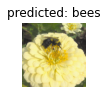

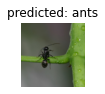

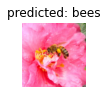

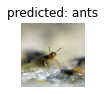

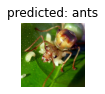

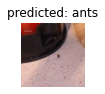

In [16]:
visualize_model(model_ft)

Exercise

Freeze weight with resnet18

In [18]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5609 Acc: 0.7008
test Loss: 0.2010 Acc: 0.9477
Epoch 2/15
train Loss: 0.4858 Acc: 0.7459
test Loss: 0.2810 Acc: 0.8758
Epoch 3/15
train Loss: 0.4250 Acc: 0.8320
test Loss: 0.1894 Acc: 0.9542
Epoch 4/15
train Loss: 0.3839 Acc: 0.8361
test Loss: 0.1824 Acc: 0.9608
Epoch 5/15
train Loss: 0.4689 Acc: 0.7705
test Loss: 0.2206 Acc: 0.9281
Epoch 6/15
train Loss: 0.3920 Acc: 0.8238
test Loss: 0.1939 Acc: 0.9542
Epoch 7/15
train Loss: 0.4346 Acc: 0.8197
test Loss: 0.2050 Acc: 0.9477
Epoch 8/15
train Loss: 0.3488 Acc: 0.8197
test Loss: 0.2044 Acc: 0.9346
Epoch 9/15
train Loss: 0.3328 Acc: 0.8607
test Loss: 0.2270 Acc: 0.9346
Epoch 10/15
train Loss: 0.3122 Acc: 0.8770
test Loss: 0.1959 Acc: 0.9542
Epoch 11/15
train Loss: 0.3588 Acc: 0.8320
test Loss: 0.2843 Acc: 0.9150
Epoch 12/15
train Loss: 0.2597 Acc: 0.8730
test Loss: 0.1838 Acc: 0.9542
Epoch 13/15
train Loss: 0.3856 Acc: 0.8402
test Loss: 0.2045 Acc: 0.9477
Epoch 14/15
train Loss: 0.4266 Acc: 0.8115
test Loss: 0.1825 Acc: 0.954

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


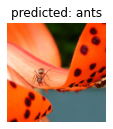

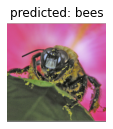

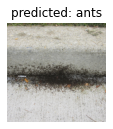

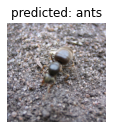

In [31]:
visualize_model(model_ft, 4)

Reconstructing layers


In [21]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
class MyAlexNET(nn.Module):
    def __init__(self):
        super(MyAlexNET, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=2, bias=True)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.softmax(x, dim=1)

In [26]:
model_myAlexNET = MyAlexNET()
print(model_myAlexNET)
model_myAlexNET = model_myAlexNET.to(device)

MyAlexNET(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)

In [27]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    train_model(model_myAlexNET, criterion, optimizer_ft)
    test_model(model_myAlexNET, criterion)
    scheduler.step()

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6932 Acc: 0.4877
test Loss: 0.6931 Acc: 0.5490
Epoch 2/15
train Loss: 0.6932 Acc: 0.4836
test Loss: 0.6931 Acc: 0.5490
Epoch 3/15
train Loss: 0.6932 Acc: 0.4631
test Loss: 0.6931 Acc: 0.5490
Epoch 4/15
train Loss: 0.6931 Acc: 0.5410
test Loss: 0.6931 Acc: 0.5490
Epoch 5/15
train Loss: 0.6930 Acc: 0.5328
test Loss: 0.6931 Acc: 0.5490
Epoch 6/15
train Loss: 0.6933 Acc: 0.4959
test Loss: 0.6931 Acc: 0.5490
Epoch 7/15
train Loss: 0.6932 Acc: 0.4795
test Loss: 0.6931 Acc: 0.5490
Epoch 8/15
train Loss: 0.6932 Acc: 0.4877
test Loss: 0.6931 Acc: 0.5490
Epoch 9/15
train Loss: 0.6934 Acc: 0.4057
test Loss: 0.6931 Acc: 0.5490
Epoch 10/15
train Loss: 0.6930 Acc: 0.5410
test Loss: 0.6931 Acc: 0.5490
Epoch 11/15
train Loss: 0.6932 Acc: 0.5164
test Loss: 0.6931 Acc: 0.5490
Epoch 12/15
train Loss: 0.6931 Acc: 0.5328
test Loss: 0.6931 Acc: 0.5490
Epoch 13/15
train Loss: 0.6933 Acc: 0.5164
test Loss: 0.6931 Acc: 0.5490
Epoch 14/15
train Loss: 0.6931 Acc: 0.5287
test Loss: 0.6931 Acc: 0.549

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


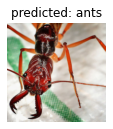

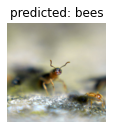

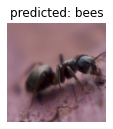

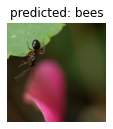

In [29]:
visualize_model(model_myAlexNET, 4)